# (31) Sim -- true generative factors

**Motivation**: Tease apart the true generative factors and aux factors, plot their correlation.  <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

    
def _sizes_hist(of, obj_i: int = 0):
    fig, ax = create_figure(1, 1, (15, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 80, 81) - 0.5, stat='percent', ax=ax)

    for color, thres in zip(['magenta', 'k', 'r'], [2, 4, 8]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    ax.legend(fontsize=17)
    plt.show()

## Prepare

In [3]:
kws = dict(
    dim=19,
    fov=45.0,
    obj_r=0.2,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 5.0),
    vlim_slf=(0.01, 5.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 4

{
    'dim': 19,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

## Category = ```Fixate```, n_obj = 1

In [4]:
%%time

of = OpticFlow(
    category='fixate',
    n=int(2e5),
    n_obj=1,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 5min 39s, sys: 29.7 s, total: 6min 8s
Wall time: 3min 24s


In [5]:
accept.sum()

165777

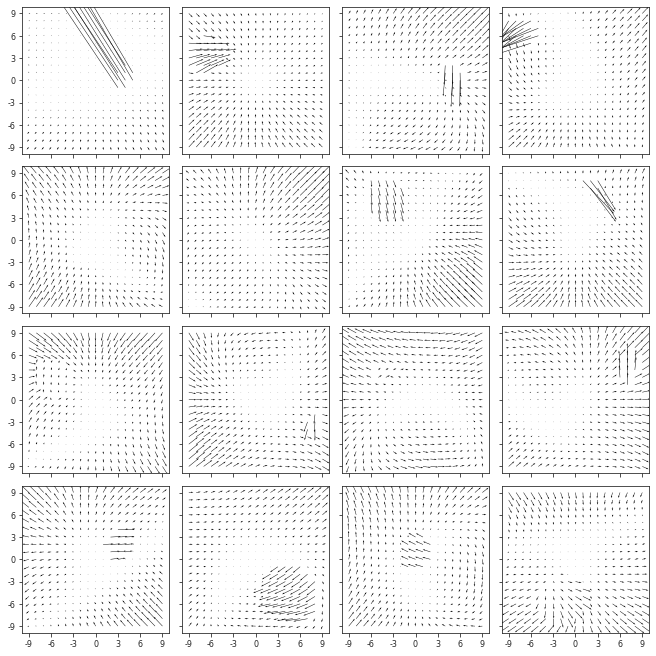

In [6]:
_ = show_opticflow(of.alpha_dot[accept])

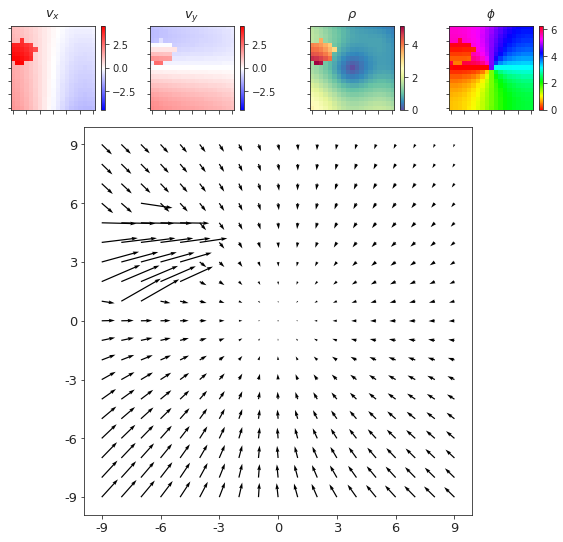

In [7]:
_ = show_opticflow_full(of.alpha_dot[accept][1])

In [8]:
of.v_slf[accept][1]

array([-0.07166029, -1.22896916, -2.23252894])

In [9]:
of.objects[0].v[accept][1]

array([ 1.31678671,  1.80615273, -0.0034045 ])

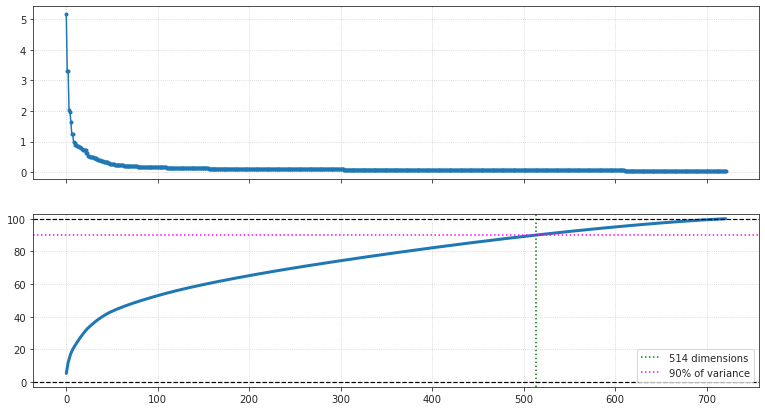

In [10]:
_plot_singular_values(s)

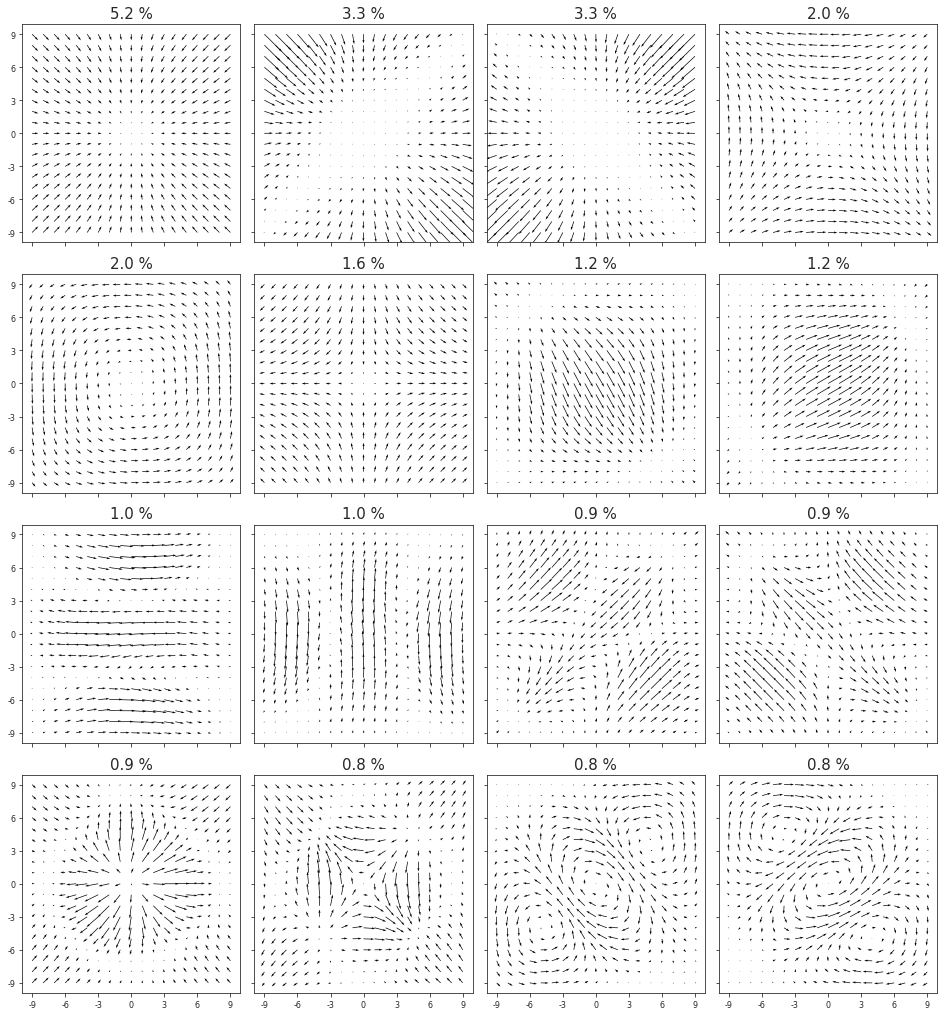

In [11]:
show_opticflow(pcs, num=4, titles=titles, scale=None, figsize=(13, 14));

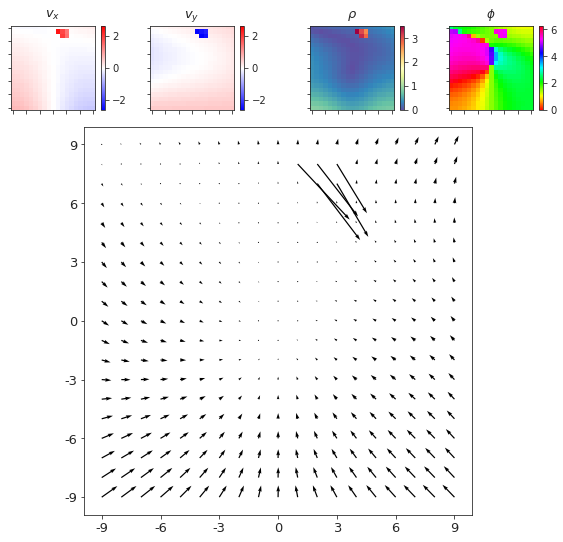

In [12]:
size_pix = of.objects[0].size * of.dim ** 2
i = np.argmin(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i], scale=18)

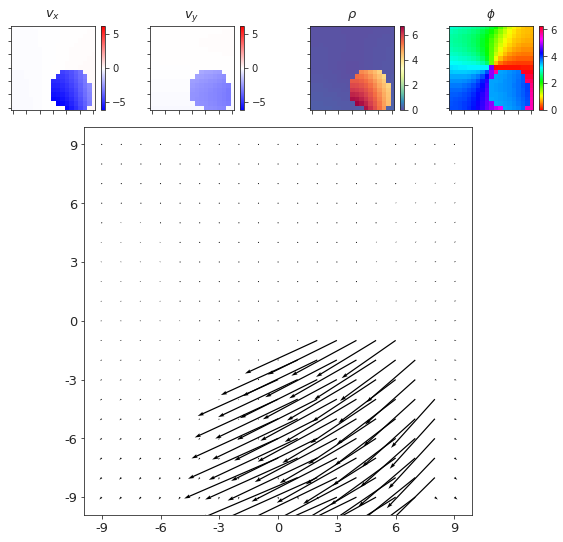

In [13]:
i = np.argmax(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i], scale=25)

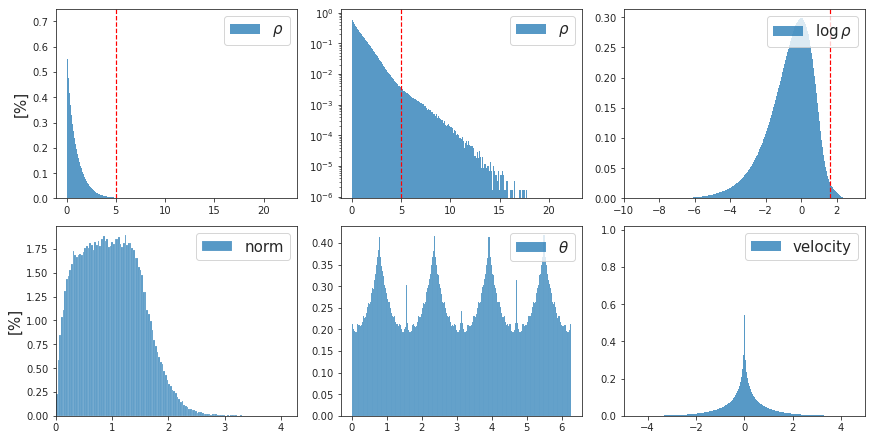

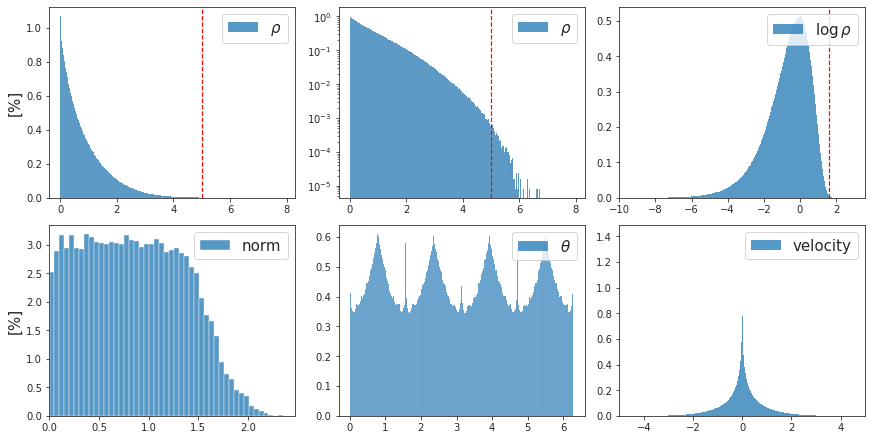

CPU times: user 4min 47s, sys: 37.3 s, total: 5min 24s
Wall time: 5min 24s


In [14]:
%%time

_ = plot_opticflow_hist(of.alpha_dot[accept])
_ = plot_opticflow_hist(of.alpha_dot[~accept])

In [15]:
q = [0.5, 0.95, 0.97, 0.99]
print(f"q = {q}\nquantiles (accept): {np.quantile(np.abs(of.alpha_dot[accept]).ravel(), q)}")

q = [0.5, 0.95, 0.97, 0.99]
quantiles (accept): [0.36746854 2.11361813 2.50673248 3.61377399]

In [16]:
q = [0.5, 0.95, 0.97, 0.99]
print(f"q = {q}\nquantiles (~accept): {np.quantile(np.abs(of.alpha_dot[~accept]).ravel(), q)}")

q = [0.5, 0.95, 0.97, 0.99]
quantiles (~accept): [0.34244847 1.8264006  2.10027992 2.59587994]

## Other hists

In [17]:
accept = of.filter(2)
accept.sum()

185394

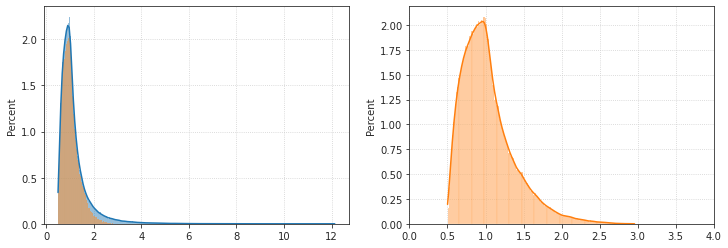

In [18]:
fig, axes = create_figure(1, 2, (12, 4))
sns.histplot(of.objects[0].r[:, 0], stat='percent', kde=True, ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], alpha=0.5,
             stat='percent', color='C1', ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], kde=True,
             stat='percent', color='C1', ax=axes[1])
axes[1].set_xlim((0, 4))
add_grid(axes)
plt.show()

In [19]:
accept = of.filter(4)
accept.sum()

165777

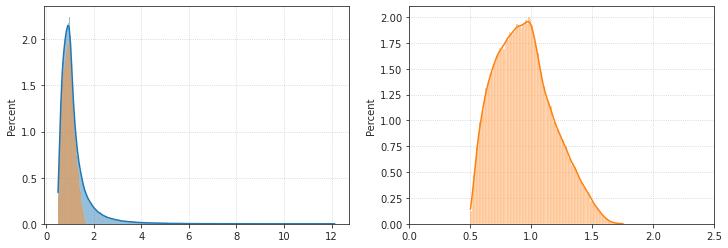

In [20]:
fig, axes = create_figure(1, 2, (12, 4))
sns.histplot(of.objects[0].r[:, 0], stat='percent', kde=True, ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], alpha=0.5,
             stat='percent', color='C1', ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], kde=True,
             stat='percent', color='C1', ax=axes[1])
axes[1].set_xlim((0, 2.5))
add_grid(axes)
plt.show()

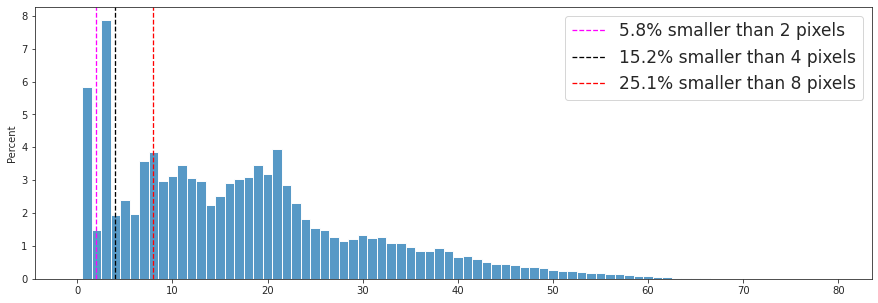

In [21]:
_sizes_hist(of)

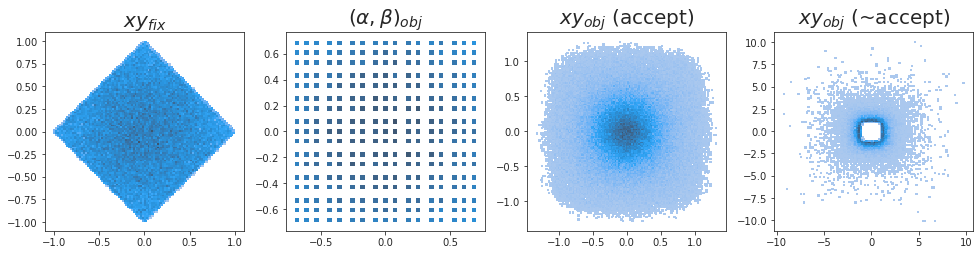

In [22]:
fig, axes = create_figure(1, 4, (13.5, 3.5), constrained_layout=True)
sns.histplot(
    x=of.fix[accept, 0],
    y=of.fix[accept, 1],
    ax=axes[0],
)
sns.histplot(
    x=of.objects[0].alpha[accept, 0],
    y=of.objects[0].alpha[accept, 1],
    ax=axes[1],
)
sns.histplot(
    x=of.objects[0].pos[accept, 0],
    y=of.objects[0].pos[accept, 1],
    ax=axes[2],
)
sns.histplot(
    x=of.objects[0].pos[~accept, 0],
    y=of.objects[0].pos[~accept, 1],
    ax=axes[3],
)

axes[0].set_title(r"$xy_{fix}$", fontsize=20)
axes[1].set_title(r"$(\alpha,\beta)_{obj}$", fontsize=20)
axes[2].set_title(r"$xy_{obj}$ (accept)", fontsize=20)
axes[3].set_title(r"$xy_{obj}$ (~accept)", fontsize=20)

ax_square(axes)
plt.show()

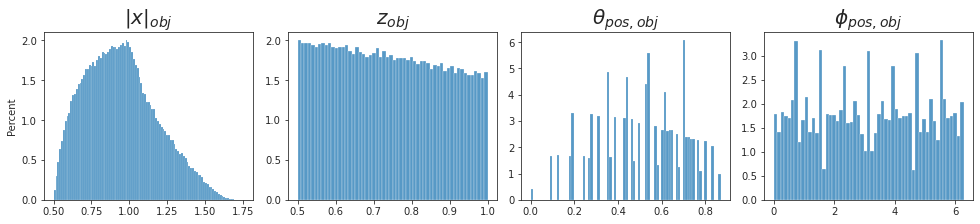

In [23]:
fig, axes = create_figure(1, 4, (13.5, 3), constrained_layout=True)
sns.histplot(of.objects[0].r[accept, 0], stat='percent', ax=axes[0])
sns.histplot(of.objects[0].pos[accept, 2], stat='percent', ax=axes[1])
sns.histplot(of.objects[0].r[accept, 1], stat='percent', ax=axes[2])
sns.histplot(of.objects[0].r[accept, 2], stat='percent', ax=axes[3])

axes[0].set_title(r"$\|x|_{obj}$", fontsize=20)
axes[1].set_title(r"$z_{obj}$", fontsize=20)
axes[2].set_title(r"$\theta_{pos, obj}$", fontsize=20)
axes[3].set_title(r"$\phi_{pos, obj}$", fontsize=20)

for ax in axes[1:].flat:
    ax.set_ylabel('')
plt.show()

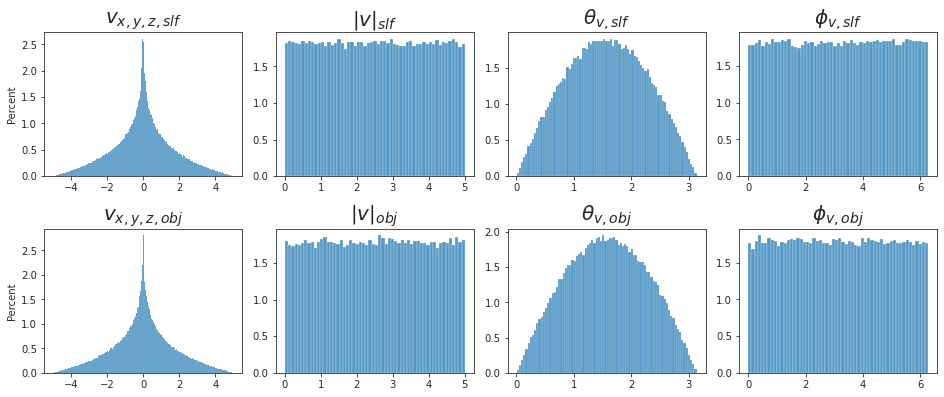

In [24]:
v_slf_polar = cart2polar(of.v_slf)
v_obj_polar = cart2polar(of.objects[0].v)

fig, axes = create_figure(2, 4, (13, 5.4), constrained_layout=True)

sns.histplot(of.v_slf[accept].ravel(), stat='percent', ax=axes[0, 0])
sns.histplot(v_slf_polar[accept, 0], stat='percent', ax=axes[0, 1])
sns.histplot(v_slf_polar[accept, 1], stat='percent', ax=axes[0, 2])
sns.histplot(v_slf_polar[accept, 2], stat='percent', ax=axes[0, 3])

sns.histplot(of.objects[0].v[accept].ravel(), stat='percent', ax=axes[1, 0])
sns.histplot(v_obj_polar[accept, 0], stat='percent', ax=axes[1, 1])
sns.histplot(v_obj_polar[accept, 1], stat='percent', ax=axes[1, 2])
sns.histplot(v_obj_polar[accept, 2], stat='percent', ax=axes[1, 3])

axes[0, 0].set_title(r"$v_{x,y,z, slf}$", fontsize=20)
axes[1, 0].set_title(r"$v_{x,y,z, obj}$", fontsize=20)
axes[0, 1].set_title(r"$|v|_{slf}$", fontsize=20)
axes[1, 1].set_title(r"$|v|_{obj}$", fontsize=20)
axes[0, 2].set_title(r"$\theta_{v, slf}$", fontsize=20)
axes[1, 2].set_title(r"$\theta_{v, obj}$", fontsize=20)
axes[0, 3].set_title(r"$\phi_{v, slf}$", fontsize=20)
axes[1, 3].set_title(r"$\phi_{v, obj}$", fontsize=20)

for ax in axes[:, 1:].flat:
    ax.set_ylabel('')
plt.show()

## Factors

In [25]:
f, g, f_aux, g_aux = of.groundtruth_factors()

### Plot correlations

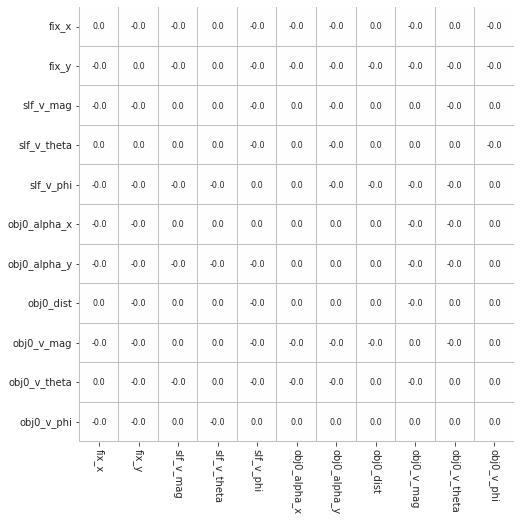

In [26]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f,
    yticklabels=f,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 8),
    cbar=False,
)
show_heatmap(rho, **kws);

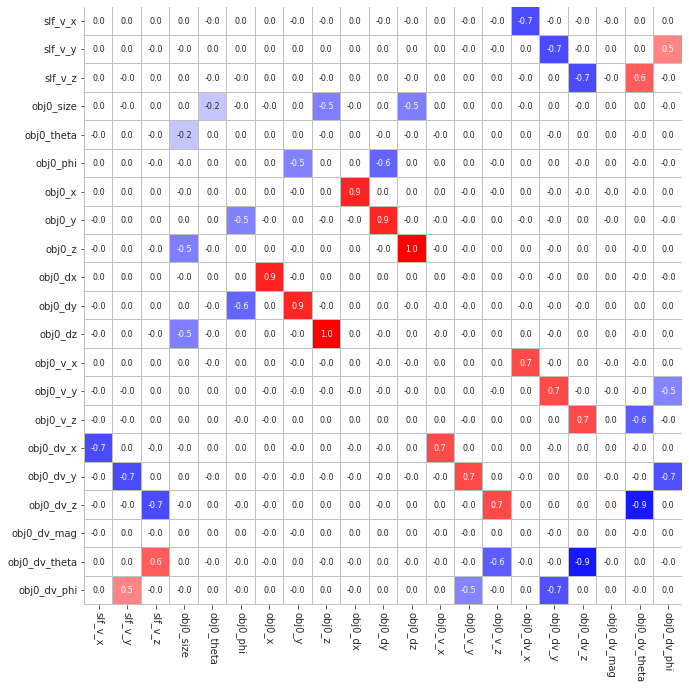

In [27]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_aux, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f_aux,
    yticklabels=f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(13, 11),
    cbar=False,
)
show_heatmap(rho, **kws);

In [28]:
g_full = np.concatenate([g, g_aux])
g_full.shape

(32, 200000)

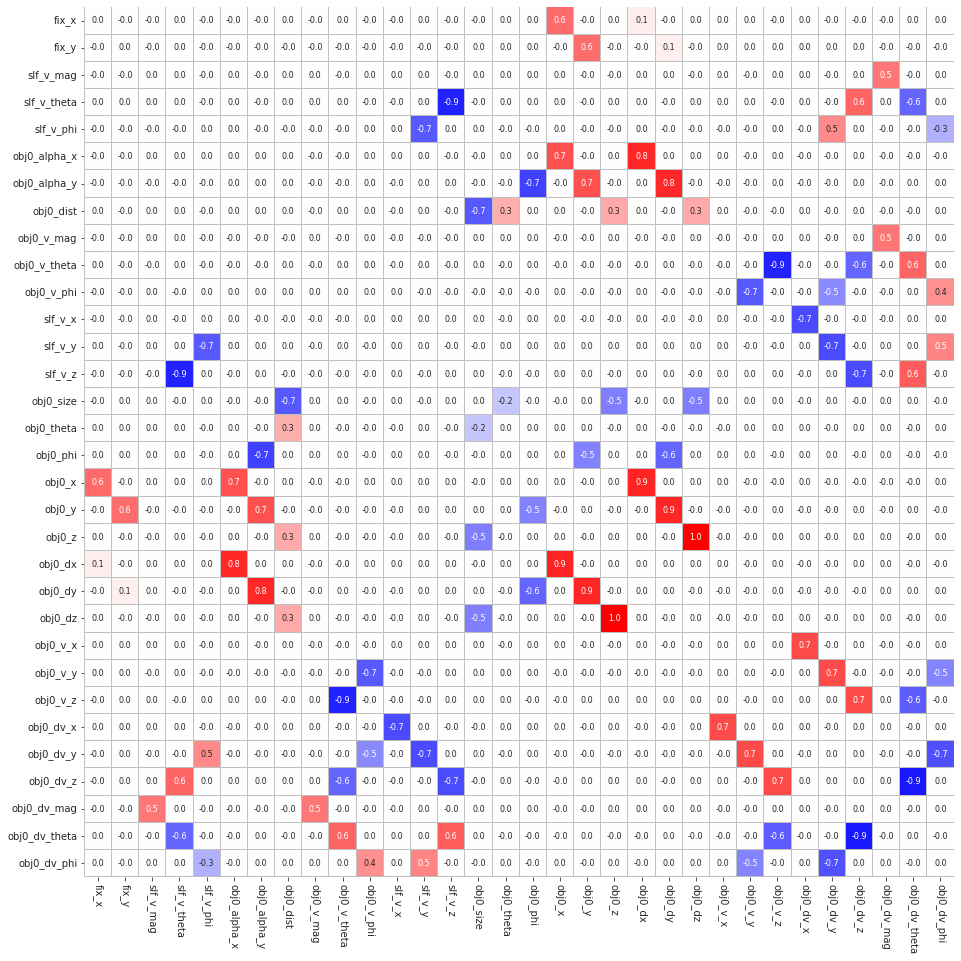

In [29]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_full, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f + f_aux,
    yticklabels=f + f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(17, 16),
    cbar=False,
)
show_heatmap(rho, **kws);

### Correlations (accepted only)

In [30]:
accept.sum()

165777

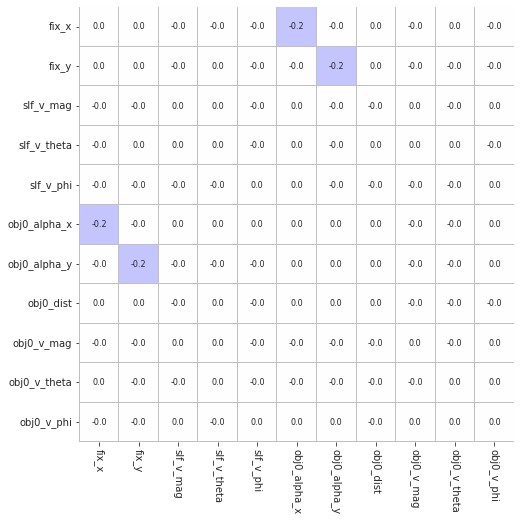

In [31]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g[:, accept], metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f,
    yticklabels=f,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 8),
    cbar=False,
)
show_heatmap(rho, **kws);

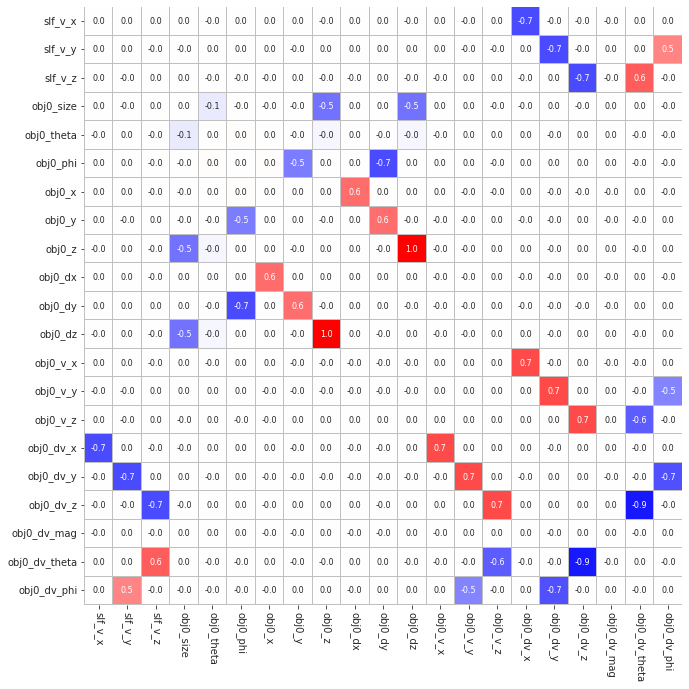

In [32]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_aux[:, accept], metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f_aux,
    yticklabels=f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(13, 11),
    cbar=False,
)
show_heatmap(rho, **kws);

In [33]:
g_full = np.concatenate([g, g_aux])
g_full.shape

(32, 200000)

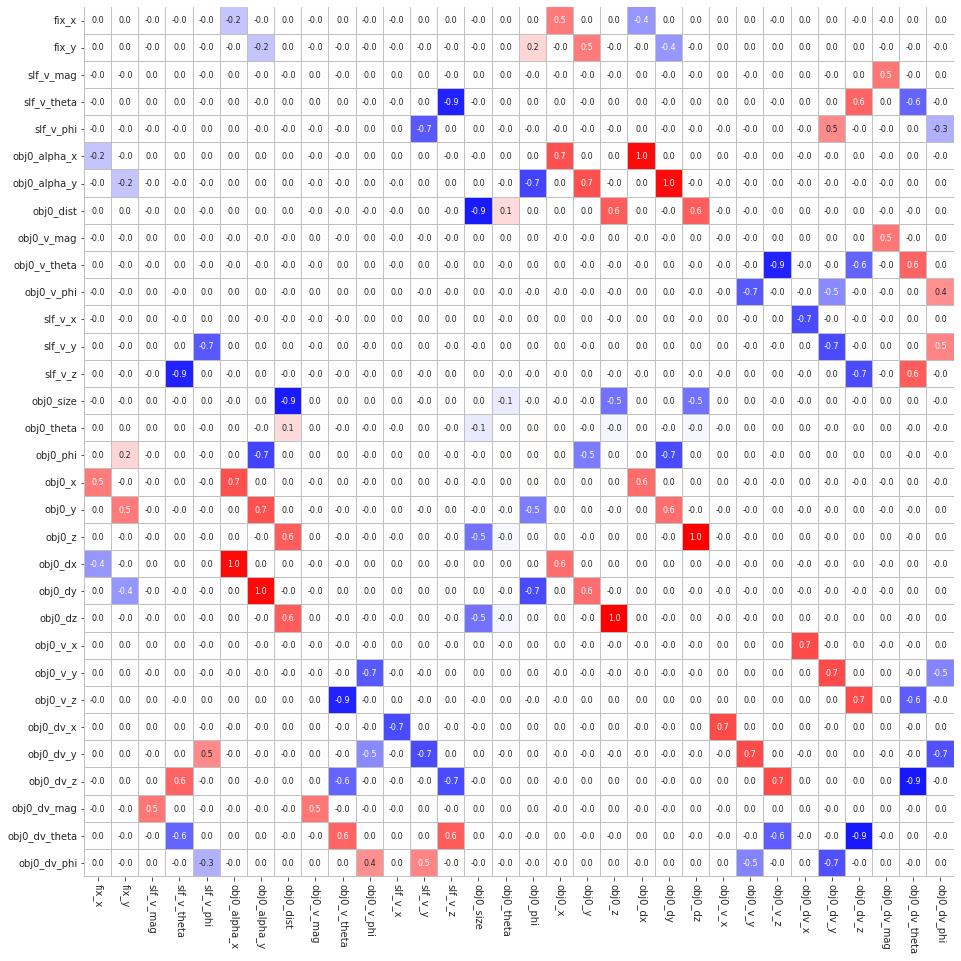

In [34]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_full[:, accept], metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f + f_aux,
    yticklabels=f + f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(17, 16),
    cbar=False,
)
show_heatmap(rho, **kws);

---
## Old code (ignore)
---

In [40]:
# true generative factors

factors = {
    'fix_x': of.fix[:, 0],
    'fix_y': of.fix[:, 1],
    'slf_v_x': of.v_slf[:, 0],
    'slf_v_y': of.v_slf[:, 1],
    'slf_v_z': of.v_slf[:, 2],
    'obj0_alpha_x': of.objects[0].alpha[:, 0],
    'obj0_alpha_y': of.objects[0].alpha[:, 1],
    'obj0_dist': of.objects[0].r[:, 0],
    'obj0_v_x': of.objects[0].v[:, 0],
    'obj0_v_y': of.objects[0].v[:, 1],
    'obj0_v_z': of.objects[0].v[:, 2],
}


# auxiliary factors

delta_x = of.objects[0].pos - of.fix
delta_v = of.objects[0].v - of.v_slf

v_slf_polar = cart2polar(of.v_slf)
dv_polar = cart2polar(delta_v)
v_obj_polar = cart2polar(of.objects[0].v)

factors_aux = {
    'slf_v_mag': v_slf_polar[:, 0],
    'slf_v_theta': v_slf_polar[:, 1],
    'slf_v_phi': v_slf_polar[:, 2],
    
    'obj0_size': of.objects[0].size,
    'obj0_theta': of.objects[0].r[:, 1],
    'obj0_phi': of.objects[0].r[:, 2],

    'obj0_x': of.objects[0].pos[:, 0],
    'obj0_y': of.objects[0].pos[:, 1],
    'obj0_z': of.objects[0].pos[:, 2],

    'obj0_dx': delta_x[:, 0],
    'obj0_dy': delta_x[:, 1],
    'obj0_dz': delta_x[:, 2],

    'obj0_v_mag': v_obj_polar[:, 0],
    'obj0_v_theta': v_obj_polar[:, 1],
    'obj0_v_phi': v_obj_polar[:, 2],

    'obj0_dv_x': delta_v[:, 0],
    'obj0_dv_y': delta_v[:, 1],
    'obj0_dv_z': delta_v[:, 2],

    'obj0_dv_mag': dv_polar[:, 0],
    'obj0_dv_theta': dv_polar[:, 1],
    'obj0_dv_phi': dv_polar[:, 2],
}

In [41]:
g = np.stack(list(factors.values()))
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

g.shape, rho.shape

((11, 13000), (11, 11))

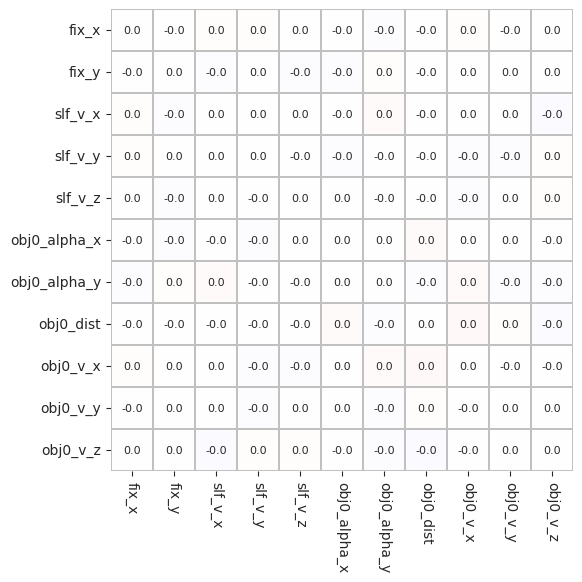

In [42]:
kws = dict(
    xticklabels=list(factors.keys()),
    yticklabels=list(factors.keys()),
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(9, 6),
    cbar=False,
)
show_heatmap(rho, **kws);

In [43]:
g = np.stack(list(factors_aux.values()))
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

g.shape, rho.shape

((21, 13000), (21, 21))

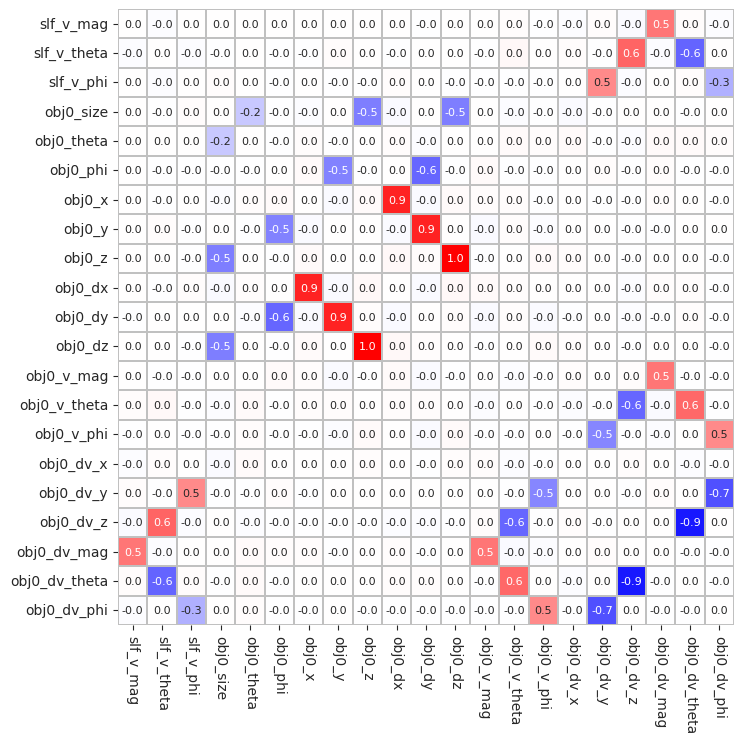

In [44]:
kws = dict(
    xticklabels=list(factors_aux.keys()),
    yticklabels=list(factors_aux.keys()),
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 8),
    cbar=False,
)
show_heatmap(rho, **kws);

In [45]:
g = np.concatenate([
    np.stack(list(factors.values())),
    np.stack(list(factors_aux.values())),
])
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

g.shape, rho.shape

((32, 13000), (32, 32))

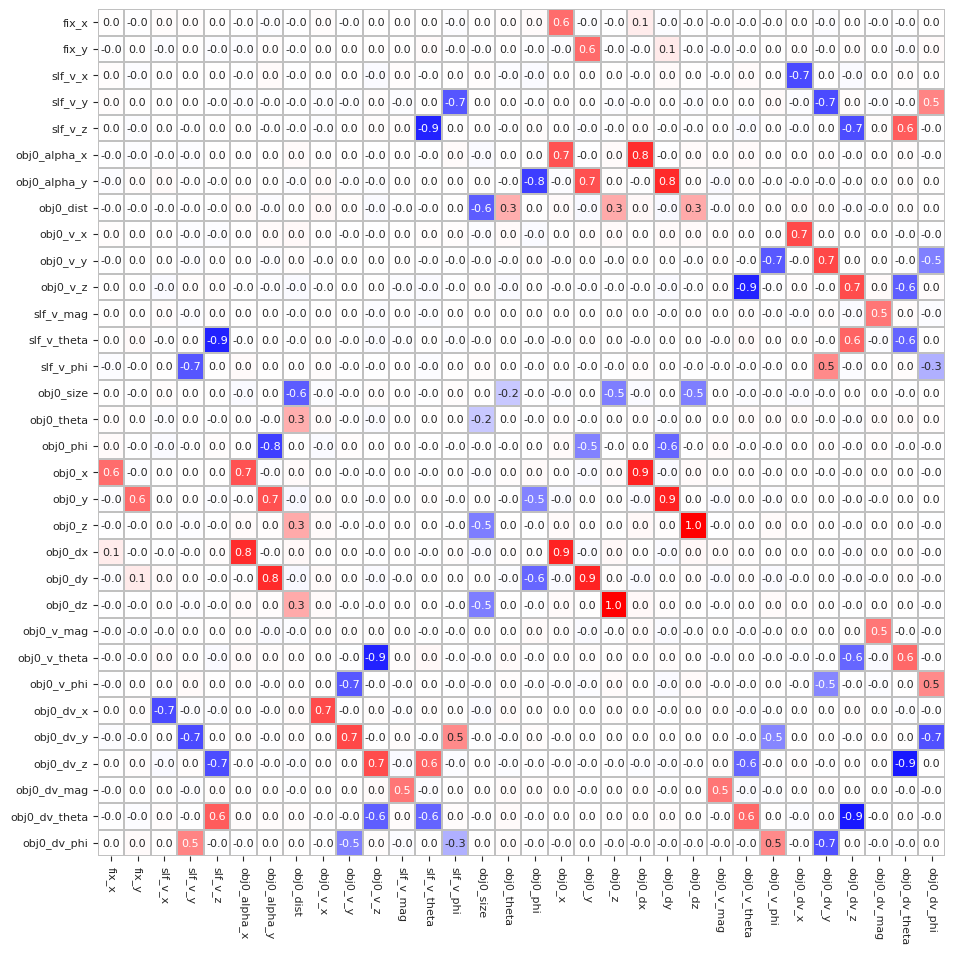

In [46]:
kws = dict(
    xticklabels=list(factors.keys()) + list(factors_aux.keys()),
    yticklabels=list(factors.keys()) + list(factors_aux.keys()),
    tick_labelsize_x=8,
    tick_labelsize_y=8,
    figsize=(13, 11),
    cbar=False,
)
show_heatmap(rho, **kws);